In [1]:
import pandas as pd

In [ ]:
!ls data/bikeshare-ridership-2023/

'Bike share ridership 2023-01.csv'  'Bike share ridership 2023-07.csv'
'Bike share ridership 2023-02.csv'  'Bike share ridership 2023-08.csv'
'Bike share ridership 2023-03.csv'  'Bike share ridership 2023-09.csv'
'Bike share ridership 2023-04.csv'  'Bike share ridership 2023-10.csv'
'Bike share ridership 2023-05.csv'  'Bike share ridership 2023-11.csv'
'Bike share ridership 2023-06.csv'  'Bike share ridership 2023-12.csv'


In [ ]:
df_jan = pd.read_csv('data/bikeshare-ridership-2023/Bike share ridership 2023-01.csv')

# TODO

## Clean the data
1. remove NaN rows
2. convert date types

## Convert to graph

- multigraph
- aggregated links

## 1- remove Nan rows

In [4]:
len(df_jan)

180135

In [5]:
df_jan = df_jan.dropna()
len(df_jan)

159636

## 2- convert date types

In [6]:
df_jan['Start Time'] = pd.to_datetime(df_jan['Start Time'])
df_jan['End Time'] = pd.to_datetime(df_jan['End Time'])
df_jan['End Station Id'] = df_jan['End Station Id'].astype(int)
df_jan = df_jan.rename(columns={"Trip  Duration": "Trip Duration"}) # I believe the duration data needs a bit cleaning. there maybe outliers.

## 3- convert to graph

- Nodes:

Bike stations in Toronto’s bikeshare system.

- Links:

Trips between bike stations (directed, weighted by trip duration).

- Objective:

Analyze usage patterns by comparing casual users vs. annual subscribers.
Identify popular routes and ridership trends.

need to build a new df with only stations and weight.

In [7]:
node_list = list(set(df_jan['Start Station Id']).union(set(df_jan['End Station Id'])))

In [8]:
df_jan_small = df_jan[['Trip Id', 'Trip Duration', 'Start Station Id', 'End Station Id']]

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(1, 10))

df_jan_small['Scaled Duration'] = scaler.fit_transform(df_jan_small[['Trip Duration']])

/tmp/ipykernel_10853/3669576720.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_jan_small['Scaled Duration'] = scaler.fit_transform(df_jan_small[['Trip Duration']])


In [10]:
df_jan_small = df_jan_small.rename(columns={"Scaled Duration": "weight"})

In [11]:
import networkx as nx

G = nx.from_pandas_edgelist(df_jan_small, source="Start Station Id", target="End Station Id", edge_attr=['weight'], create_using=nx.DiGraph, edge_key='Trip Id')

In [12]:
G.number_of_nodes(), G.number_of_edges()

(580, 51133)

In [13]:
nx.adjacency_matrix(G, weight=None).toarray()

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [14]:
## another way for aggregation of parallel links

temp_df = df_jan_small[['Start Station Id', 'End Station Id', 'Trip Id']].groupby(['Start Station Id', 'End Station Id']).count().reset_index().rename(columns={"Trip Id": "trips"})
# temp_df
temp_df['duration'] = df_jan_small[['Start Station Id', 'End Station Id', 'weight']].groupby(['Start Station Id', 'End Station Id']).mean().reset_index()['weight']

Gagg_new = nx.from_pandas_edgelist(temp_df, source="Start Station Id", target="End Station Id", edge_attr=['trips', 'duration'], create_using=nx.DiGraph)

## measurements

### Degree Distribution

In [15]:
import matplotlib.pyplot as plt
import numpy as np


in_degrees = [deg for (id, deg) in G.in_degree()]
out_degrees = [deg for (id, deg) in G.out_degree()]

in_kmin = min(in_degrees)
in_kmax = max(in_degrees)
out_kmin = min(out_degrees)
out_kmax = max(out_degrees)

In [16]:
# Get 10 logarithmically spaced bins between kmin and kmax
in_bin_edges = np.logspace(np.log10(in_kmin + 1e-1), np.log10(in_kmax), num=10)

# histogram the data into these bins
in_density, _ = np.histogram(in_degrees, bins=in_bin_edges, density=True)

# Get 10 logarithmically spaced bins between kmin and kmax
out_bin_edges = np.logspace(np.log10(out_kmin + 1e-1), np.log10(out_kmax), num=10)

# histogram the data into these bins
out_density, _ = np.histogram(out_degrees, bins=out_bin_edges, density=True)

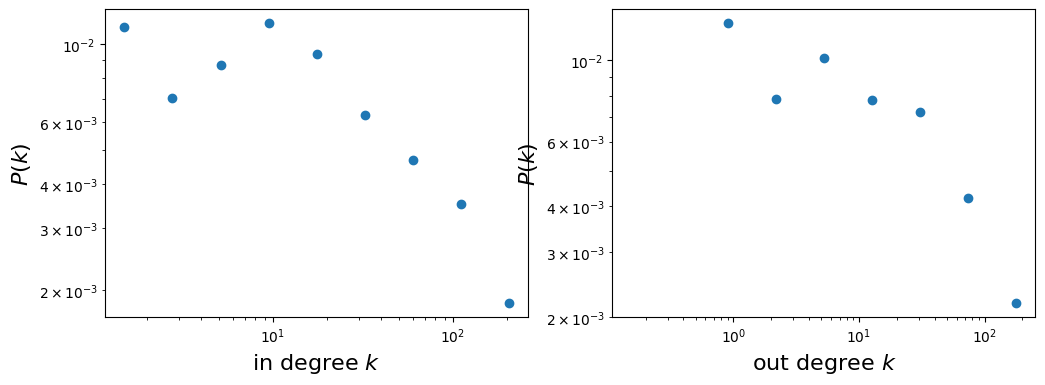

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

# "x" should be midpoint (IN LOG SPACE) of each bin
in_log_be = np.log10(in_bin_edges)
in_x = 10**((in_log_be[1:] + in_log_be[:-1])/2)

out_log_be = np.log10(out_bin_edges)
out_x = 10**((out_log_be[1:] + out_log_be[:-1])/2)

ax1.loglog(in_x, in_density, marker='o', linestyle='none')
ax1.set_xlabel(r"in degree $k$", fontsize=16)
ax1.set_ylabel(r"$P(k)$", fontsize=16)

ax2.loglog(out_x, out_density, marker='o', linestyle='none')
ax2.set_xlabel(r"out degree $k$", fontsize=16)
ax2.set_ylabel(r"$P(k)$", fontsize=16)

# Show the plot
plt.show()

In [18]:
# Get 20 logarithmically spaced bins between kmin and kmax
in_bin_edges = np.linspace(in_kmin, in_kmax, num=10)
out_bin_edges = np.linspace(out_kmin, out_kmax, num=10)

# histogram the data into these bins
in_density, _ = np.histogram(in_degrees, bins=in_bin_edges, density=True)
out_density, _ = np.histogram(out_degrees, bins=out_bin_edges, density=True)

/tmp/ipykernel_10853/3300156871.py:7: RuntimeWarning: divide by zero encountered in log10
  out_log_be = np.log10(out_bin_edges)


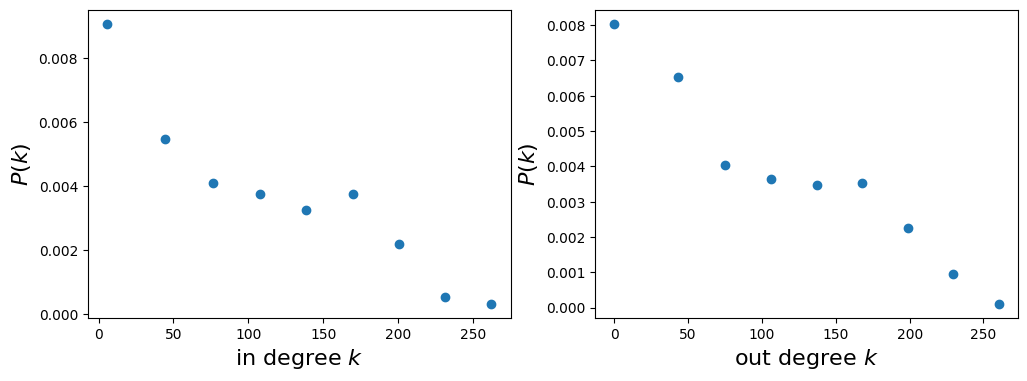

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

# "x" should be midpoint (IN LOG SPACE) of each bin
in_log_be = np.log10(in_bin_edges)
in_x = 10**((in_log_be[1:] + in_log_be[:-1])/2)

out_log_be = np.log10(out_bin_edges)
out_x = 10**((out_log_be[1:] + out_log_be[:-1])/2)

ax1.plot(in_x, in_density, marker='o', linestyle='none')
ax1.set_xlabel(r"in degree $k$", fontsize=16)
ax1.set_ylabel(r"$P(k)$", fontsize=16)

ax2.plot(out_x, out_density, marker='o', linestyle='none')
ax2.set_xlabel(r"out degree $k$", fontsize=16)
ax2.set_ylabel(r"$P(k)$", fontsize=16)

# Show the plot
plt.show()

### Average Shortest Path Length

In [15]:
largest = max(nx.strongly_connected_components(G), key=len)
G_strongly_connected = G.subgraph(largest)

In [16]:
nx.average_shortest_path_length(G_strongly_connected, weight='weight', method='dijkstra')

2.1124088286818585

In [17]:
0.00040404833316101305 * df_jan['Trip Duration'].max()

704.116443976372

### Clustering Coefficient

In [104]:
nx.average_clustering(G, weight='weight')

NetworkXNotImplemented: not implemented for multigraph type

### betweenness centrality

In [50]:
## another way for aggregation of parallel links

temp_df = df_jan_small[['Start Station Id', 'End Station Id', 'Trip Id']].groupby(['Start Station Id', 'End Station Id']).count().reset_index().rename(columns={"Trip Id": "trips"})
temp_df['duration'] = df_jan_small[['Start Station Id', 'End Station Id', 'Trip Duration']].groupby(['Start Station Id', 'End Station Id']).mean().reset_index()['Trip Duration'].astype(int)
Gagg_new = nx.from_pandas_edgelist(temp_df, source="Start Station Id", target="End Station Id", edge_attr=['trips', 'duration'], create_using=nx.DiGraph)

In [54]:
# we have node shortest path betweenness centrality
nx.betweenness_centrality(G, weight='duration')

{7399: 0.0032549042193973196,
 7533: 0.0021080505285550025,
 7269: 0.003712224530428393,
 7076: 0.009646512016994064,
 7078: 0.008820756660798372,
 7061: 0.006291046659883389,
 7382: 0.0023679293283815264,
 7033: 0.008479076813107797,
 7569: 0.000996891717262825,
 7075: 0.0007092894281924254,
 7059: 0.0015659897084495066,
 7161: 0.0019496379169342654,
 7098: 0.0009298156074934883,
 7164: 0.002493562478638791,
 7257: 0.002917525921092829,
 7100: 0.004421641835583834,
 7040: 0.0028028315411822422,
 7154: 0.002394037606280797,
 7373: 0.0010064327389630182,
 7167: 0.00014992213562090817,
 7475: 0.0017165181596620828,
 7242: 0.0032039560316537295,
 7430: 0.0039072906377161255,
 7190: 0.0037087574063504416,
 7026: 0.0024783343145066946,
 7101: 0.0008816641552061387,
 7526: 0.0013626778503787423,
 7297: 0.00040926302927115114,
 7368: 0.0031183146420307476,
 7239: 0.005337279072736427,
 7493: 0.000184576963601947,
 7407: 0.00192553990088841,
 7502: 0.0022291959129965306,
 7524: 0.0040913150659

In [53]:
# again the aggregated method produces similar results with multigraph in unweighted mode (we can show correlation)
nx.betweenness_centrality(Gagg_new, weight='duration') 

{7000: 0.0022156683459729517,
 7002: 0.002641471096210505,
 7004: 0.005068795780020837,
 7005: 0.0032913805570994018,
 7006: 0.037507993139346565,
 7007: 0.0007783973083290006,
 7009: 0.0018780142352582607,
 7010: 0.001828710758914965,
 7012: 0.026942108754504545,
 7015: 0.009272041642014929,
 7016: 8.067841583448375e-05,
 7018: 0.0010144563768817493,
 7020: 0.0001494044737675625,
 7021: 0.015888667770267713,
 7022: 0.00037201713968123065,
 7027: 0.0013755171884866921,
 7033: 0.001972139053731825,
 7035: 0.002087180498532848,
 7037: 0.0013521104875964406,
 7038: 9.860695268659125e-05,
 7039: 0.004144480102312184,
 7040: 0.00126694993754893,
 7041: 0.00048705858448225373,
 7043: 0.0033416800632678142,
 7045: 0.0093636763859257,
 7046: 0.002039869081839787,
 7047: 0.012279553698955961,
 7048: 0.0029537264463847107,
 7052: 0.003100142830676922,
 7053: 0.08806347897281437,
 7054: 0.0020692519616807405,
 7057: 0.10325641991023779,
 7058: 0.0033197674071152386,
 7059: 0.007047409027615924,
 

In [56]:
nx.edge_betweenness_centrality(G)

{(7399, 7533, 20148785): 4.403244187636218e-06,
 (7399, 7533, 20312831): 4.403244187636218e-06,
 (7399, 7533, 20337706): 4.403244187636218e-06,
 (7399, 7533, 20341282): 4.403244187636218e-06,
 (7399, 7055, 20148860): 1.715600131388568e-05,
 (7399, 7006, 20148867): 7.08828924813817e-06,
 (7399, 7006, 20148869): 7.08828924813817e-06,
 (7399, 7006, 20159458): 7.08828924813817e-06,
 (7399, 7006, 20220568): 7.08828924813817e-06,
 (7399, 7030, 20148941): 7.89222493004513e-06,
 (7399, 7030, 20148948): 7.89222493004513e-06,
 (7399, 7030, 20148957): 7.89222493004513e-06,
 (7399, 7030, 20148959): 7.89222493004513e-06,
 (7399, 7030, 20148963): 7.89222493004513e-06,
 (7399, 7030, 20316076): 7.89222493004513e-06,
 (7399, 7417, 20149187): 2.66029315286466e-06,
 (7399, 7417, 20170593): 2.66029315286466e-06,
 (7399, 7417, 20230881): 2.66029315286466e-06,
 (7399, 7417, 20275297): 2.66029315286466e-06,
 (7399, 7417, 20321163): 2.66029315286466e-06,
 (7399, 7000, 20149838): 1.770058358898359e-05,
 (7399,

In [55]:
nx.edge_betweenness_centrality(Gagg_new, weight='duration')

{(7000, 7000): 0.0,
 (7000, 7002): 0.0,
 (7000, 7004): 0.0,
 (7000, 7005): 0.0,
 (7000, 7006): 0.0,
 (7000, 7007): 0.0,
 (7000, 7009): 0.0,
 (7000, 7010): 5.955571437079388e-06,
 (7000, 7012): 0.0,
 (7000, 7015): 2.977785718539694e-06,
 (7000, 7016): 5.955571437079388e-06,
 (7000, 7018): 1.488892859269847e-05,
 (7000, 7020): 2.977785718539694e-06,
 (7000, 7021): 0.0,
 (7000, 7022): 0.0,
 (7000, 7027): 0.0,
 (7000, 7033): 2.977785718539694e-06,
 (7000, 7035): 0.0,
 (7000, 7037): 0.0,
 (7000, 7038): 2.977785718539694e-06,
 (7000, 7039): 0.0,
 (7000, 7040): 0.0,
 (7000, 7041): 0.0,
 (7000, 7043): 0.0,
 (7000, 7045): 1.1911142874158776e-05,
 (7000, 7046): 0.0,
 (7000, 7047): 0.0,
 (7000, 7048): 0.0,
 (7000, 7052): 3.871121434101602e-05,
 (7000, 7053): 0.0,
 (7000, 7054): 6.551128580787326e-05,
 (7000, 7057): 2.977785718539694e-06,
 (7000, 7058): 0.0,
 (7000, 7059): 5.955571437079388e-06,
 (7000, 7062): 8.933357155619082e-06,
 (7000, 7064): 0.0,
 (7000, 7065): 0.0,
 (7000, 7067): 2.97778571

In [57]:
# there is also communicability betweenness
nx.communicability_betweenness_centrality(G) # does not work for multigraph

NetworkXNotImplemented: not implemented for multigraph type

In [58]:
nx.communicability_betweenness_centrality(Gagg_new)

NetworkXNotImplemented: not implemented for directed type

In [60]:
# current flow betweenness centrality which is hopefully the same as random-walk centrality

nx.current_flow_closeness_centrality(Gagg_new)

NetworkXNotImplemented: not implemented for directed type

### closeness centrality

In [105]:
shortest_weighted_paths = list(nx.shortest_path_length(G, weight='weight')) ## only has keys if there is a path

In [107]:
efficiency = {}

for node, distance_dict in shortest_weighted_paths:

    inverse_sum = 0

    for target, length in distance_dict.items():

        if target == node:
            continue

        inverse_sum += (1 / length)

    efficiency[node] = inverse_sum    

In [108]:
efficiency

{7399: 354.0055294607101,
 7533: 331.7327491024741,
 7269: 377.90111820091806,
 7076: 374.0625895428522,
 7078: 381.7165543874572,
 7061: 373.27125987317714,
 7382: 368.4048098176875,
 7033: 392.6429236621877,
 7569: 282.80496855797327,
 7075: 309.5774339926789,
 7059: 353.16076520066895,
 7161: 358.683825988371,
 7098: 314.1429050988483,
 7164: 371.9367506210965,
 7257: 374.12397451314223,
 7100: 381.72963460640125,
 7040: 349.4380023094416,
 7154: 349.26183037884834,
 7373: 329.2705863500274,
 7167: 302.0502704521835,
 7475: 357.2464498648354,
 7242: 293.250950782523,
 7430: 290.37535516064355,
 7190: 372.50999083948614,
 7026: 365.85143364872823,
 7101: 320.4026944911759,
 7526: 309.98082073955584,
 7297: 290.574092196842,
 7368: 341.53698735191864,
 7239: 365.14782549317476,
 7493: 292.6442177865195,
 7407: 334.14173104830707,
 7502: 369.75367337433255,
 7524: 352.7514128458213,
 7329: 329.6609154777717,
 7261: 347.0671992512829,
 7452: 341.68996746595445,
 7264: 339.7088985744397,

In [193]:
# create weighted graph from M
Gagg = nx.DiGraph()
for u,v,data in G.edges(data=True):
    # w = data['weight'] if 'weight' in data else 1.0
    w = data['weight']
    if Gagg.has_edge(u,v):
        Gagg[u][v]['duration'] += w
        Gagg[u][v]['trips'] += 1
    else:
        Gagg.add_edge(u, v, duration=w, trips=1)

for u,v in Gagg.edges():
    Gagg[u][v]['duration'] /= Gagg[u][v]['trips']


In [194]:
shortest_weighted_paths = list(nx.shortest_path_length(Gagg, weight='duration'))

In [195]:
efficiency = {}

for node, distance_dict in shortest_weighted_paths:

    inverse_sum = 0

    for target, length in distance_dict.items():

        if target == node:
            continue

        inverse_sum += (1 / length)

    efficiency[node] = inverse_sum    

In [196]:
efficiency ## interesting thing is that this is really similar to when we did it on MultiDiGraph

{7399: 353.69115996115534,
 7533: 331.5084420929759,
 7055: 356.98286735109076,
 7006: 417.6745235308511,
 7030: 381.5304278483669,
 7417: 347.65599584765016,
 7000: 362.54564960750844,
 7022: 387.209694582734,
 7045: 362.6207502739495,
 7375: 345.5584604559292,
 7492: 280.8881050400384,
 7409: 357.06774460971076,
 7121: 371.34528423679114,
 7577: 325.3364763354559,
 7467: 351.8596564801395,
 7076: 373.7279603578736,
 7075: 309.46620082795465,
 7261: 346.93085635253124,
 7603: 250.16152493614533,
 7299: 331.12494609776246,
 7321: 353.03076846849825,
 7291: 325.76184616804096,
 7551: 322.8284979983834,
 7171: 290.33178062814693,
 7356: 337.257232522879,
 7168: 345.78585357048485,
 7127: 317.26225024059676,
 7026: 365.5638777651568,
 7054: 346.21417344987765,
 7263: 386.48762164529114,
 7099: 331.3238943985689,
 7259: 320.4299495286213,
 7009: 343.8940482741709,
 7657: 311.4274175630232,
 7107: 297.14877525451215,
 7275: 349.3327627074072,
 7070: 314.4019021457219,
 7202: 353.67586770053

In [182]:
## another way for aggregation of parallel links

temp_df = df_jan_small[['Start Station Id', 'End Station Id', 'Trip Id']].groupby(['Start Station Id', 'End Station Id']).count().reset_index().rename(columns={"Trip Id": "trips"})
# temp_df
temp_df['duration'] = df_jan_small[['Start Station Id', 'End Station Id', 'weight']].groupby(['Start Station Id', 'End Station Id']).mean().reset_index()['weight']

In [197]:
Gagg_new = nx.from_pandas_edgelist(temp_df, source="Start Station Id", target="End Station Id", edge_attr=['trips', 'duration'], create_using=nx.DiGraph)

In [198]:
shortest_weighted_paths = list(nx.shortest_path_length(Gagg_new, weight='duration'))

In [199]:
efficiency = {}

for node, distance_dict in shortest_weighted_paths:

    inverse_sum = 0

    for target, length in distance_dict.items():

        if target == node:
            continue

        inverse_sum += (1 / length)

    efficiency[node] = inverse_sum    

In [200]:
efficiency[7399]

353.69115996115534

وزنها خیلی کوچیکن نیازی نیست اینطور باشه. 

برای اینکه فرمول آلفا دار رو استفاده کنیم میتونیم وزن جدید بسازیم و به توان آلفا برسونیم و بعد شورتست پث بدست بیاریم. 

میشه از جی پی یو استفاده کرد.

### eigenvector centrality

In [72]:
nx.eigenvector_centrality(G, weight='weight')

NetworkXNotImplemented: not implemented for multigraph type

### degree centrality

In [68]:
nx.degree_centrality(G)[7399]

2.5682210708117443

In [69]:
nx.out_degree_centrality(G)[7399] + nx.in_degree_centrality(G)[7399]

2.5682210708117443

In [ ]:
nx.in_degree_centrality(G), nx.out_degree_centrality(G)

### pagerank centrality

In [73]:
nx.pagerank(G, weight='weight')

{7399: 0.0039725715003227965,
 7533: 0.002454502244499643,
 7269: 0.004138739820321257,
 7076: 0.006738137349618203,
 7078: 0.003345223756555224,
 7061: 0.003449864415544378,
 7382: 0.0032223243325247637,
 7033: 0.009058669029827805,
 7569: 0.0008674704155480684,
 7075: 0.0012976628373324098,
 7059: 0.0036538651357361494,
 7161: 0.0026006904209751594,
 7098: 0.0014623647518491752,
 7164: 0.0045570190758066256,
 7257: 0.0038695343047451094,
 7100: 0.004755517587112946,
 7040: 0.001786470532935717,
 7154: 0.0017869979349200422,
 7373: 0.0017074955219825733,
 7167: 0.000637440551710969,
 7475: 0.0028868172475612665,
 7242: 0.001481761812146552,
 7430: 0.0015007499131114792,
 7190: 0.0028894698713693642,
 7026: 0.002729564093078631,
 7101: 0.0019120765977480437,
 7526: 0.0011501507664955842,
 7297: 0.0007076129840203686,
 7368: 0.001860480962673763,
 7239: 0.0023839663193563777,
 7493: 0.001518795306671478,
 7407: 0.0018899837082701387,
 7502: 0.0024194446292689193,
 7524: 0.00332231265116

In [78]:
G_temp = nx.MultiDiGraph()

G_temp.add_edge(1, 2, w=2)
G_temp.add_edge(1, 3, w=1)
G_temp.add_edge(3, 2, w=1)
G_temp.add_edge(2, 4, w=3)

nx.pagerank(G_temp)

{1: 0.12045209234069676,
 2: 0.3175410567582492,
 3: 0.1716439352034471,
 4: 0.39036291569760717}

In [81]:
G_temp = nx.MultiDiGraph()

G_temp.add_edge(1, 2, w=2)
G_temp.add_edge(1, 3, w=1)
G_temp.add_edge(1, 3, w=2)
G_temp.add_edge(1, 3, w=3)
G_temp.add_edge(3, 2, w=1)
G_temp.add_edge(2, 4, w=3)

nx.pagerank(G_temp, weight='w')

{1: 0.11826462489539454,
 2: 0.30800683007760565,
 3: 0.1936588998557523,
 4: 0.38006964517124764}

### motifs analyses

In [ ]:
# should be continued in bct and then move the results back here for demonstration

In [25]:
unweighted = nx.adjacency_matrix(Gagg_new, weight=None).toarray()

In [26]:
trips_weighted = nx.adjacency_matrix(Gagg_new, weight='trips').toarray()

In [27]:
duration_weighted = nx.adjacency_matrix(Gagg_new, weight='duration').toarray()

In [28]:
from scipy.io import savemat

savemat('test.mat', {'uw': unweighted, 'trips_w': trips_weighted, 'duration_w': duration_weighted})

```matlab
>> uw = cast(uw, 'double');
>> [F, f] = motif3struct_bin(uw);
>> disp(F);
      252729
      475419
      230611
      741469
       97019
      683467
       28629
      101794
      446463
      178526
       96556
      401673
      225199
```

```matlab
>> S = sum(f, 2) / 3

S =

      252729
      475419
      230611
      741469
       97019
      683467
       28629
      101794
      446463
      178526
       96556
      401673
      225199
```

```
motif3struct_wei.m:
%   Input:      W,      weighted directed connection matrix
%                       (all weights must be between 0 and 1)
%
%   Output:     I,      node motif intensity fingerprint
%               Q,      node motif coherence fingerprint
%               F,      node motif frequency fingerprint
%
%   Notes: 
%       1. The function find_motif34.m outputs the motif legend.
%       2. Average intensity and coherence are given by I./F and Q./F
%       3. All weights must be between 0 and 1. This may be achieved using
%          the weight_conversion.m function, as follows:
%          W_nrm = weight_conversion(W, 'normalize');
```

```matlab
>> trips_w = cast(trips_w, 'double');
>> trips_w_norm = weight_conversion(trips_w, 'normalize');
>> [I, Q, F] = motif3struct_wei(trips_w_norm);
>> disp(size(F));
    13   580

>> S = sum(F, 2) / 3

S =

      252729
      475419
      230611
      741469
       97019
      683467
       28629
      101794
      446463
      178526
       96556
      401673
      225199
```

The sum over the rows of node motif frequency fingerprint in both weighted and unweighted are the same. I should dig into what these three outputs are in weighted mode. The same was true for both trip counts and duration of travel as weight. It just doesn't matter what the weights are, the frequency stays the same.

### small-worldness

we have two definitions, one only uses random network to decide small-worlds and the other uses both randomized and latticized networks. bct supports randomization, latticization, shortest path and clustering coefficient calculation for weighted directed networks.<br>
<br>
for shortest path length:<br>
distance_wei.m (WU, WD networks): distance matrix (Dijkstra's algorithm). The input matrix must be a mapping from weight to distance (usually weight inversion).<br>
or<br>
charpath.m (BU, BD, WU, WD networks).<br>

infinity is still present!? need harmonic mean to just get rid of the infinity. this is the same as the global efficiency in charpath.m.
we might just use efficiency instead of average shortest path length? but since path length is related to the inverse of efficiency, I might need to reconsider small-world definition. (look up). we can then inverse the efficiency and call it 'the_measurement' to get a measure that increases with an increase in characteristic path length. this way we can characterize the small-world feature with lower clustering coefficient than lattice and also, higher average path length (not too high) -> lower efficiency -> higher amount of 'the_measurement'.

<br>
for clustering coefficient:<br>
clustering_coef_wd.m (WD networks).<br>

How do you get infinite clustering coefficient wtf?!

<br>
degree preserving randomization:<br>
randmio_dir.m; randmio_dir_connected.m; randmio_dir_signed (BD, WD networks): These functions preserve the out-strength but not the in-strength distributions in weighted networks. The connected version of the function ensures that the randomized network does not disconnect.<br>
<br>
network latticization:<br>
latmio_dir.m; latmio_dir_connected.m (BD, WD networks): These functions preserve the out-strength but not the in-strength distributions in weighted networks. The connected version of the function ensures that the latticized network does not disconnect.<br>

```matlab
>> trips_w = cast(trips_w, 'double');
>> uw = cast(uw, 'double');
>> duration_w_norm = weight_conversion(duration_w, 'normalize');
>> [duration_D, duration_B] = distance_wei(duration_w_norm);
>> [lambda, efficiency, ecc, radius, diameter] = charpath(duration_D);
>> disp(efficiency)
    5.2358

let's use networkx to do the efficiency. first I want to see the Watts-Strogatz Model. <br>

#### Watts-Strogatz Model

In [93]:
import networkx as nx

# G_ws = nx.grid_graph((4, 4), True)
# G_ws = nx.random_regular_graph(3, 10)
# G_ws = nx.hexagonal_lattice_graph(3, 3)
G_ws = nx.triangular_lattice_graph(10, 10)

In [94]:
print(f"clustering coefficient is: {nx.average_clustering(G_ws)}")
print(f"characteristic path length is: {nx.average_shortest_path_length(G_ws)}")

clustering coefficient is: 0.47474747474747453
characteristic path length is: 4.544055944055944


In [60]:
import random

def get_rewired(G, p=0.5):

    G_new = G.__class__()
    G_new.add_nodes_from(G)
        
    nodes = list(G.nodes())
    
    for edge in G.edges():
        if random.random() < p:
            u, v = edge
            
            ## rewire either side
            if random.random() < 0.5: # first node changes            
                while True:
                    new_node = random.choice(nodes)
                    if new_node != u and new_node != v:
                        break
                G_new.add_edge(new_node, v)
            else: # second node changes
                while True:
                    new_node = random.choice(nodes)
                    if new_node != v and new_node != u:
                        break
                G_new.add_edge(u, new_node)
        else:
            G_new.add_edge(*edge)

    if nx.is_connected(G_new):
        return G_new
    else:
        return get_rewired(G, p)

In [101]:
import numpy as np

ps = np.logspace(-4, 0, 20)

clustering_coefs = []
path_lengths = []

c0 = nx.average_clustering(G_ws)
d0 = nx.average_shortest_path_length(G_ws)

for p in ps:

    G_new = get_rewired(G_ws, p=p)

    clustering_coef_new = nx.average_clustering(G_new)
    path_length_new = nx.average_shortest_path_length(G_new)

    clustering_coefs.append(clustering_coef_new / c0)
    path_lengths.append(path_length_new / d0)
    

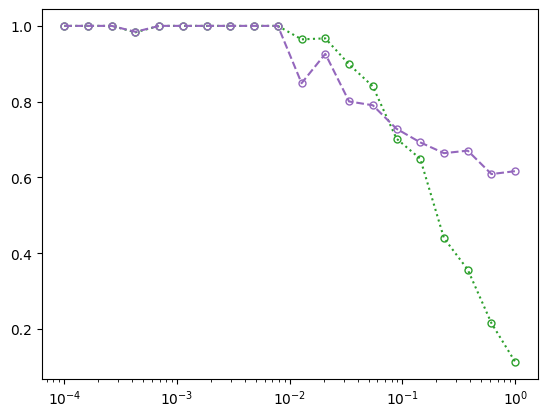

In [102]:
fig, ax = plt.subplots()

marker_style = dict(color='tab:green', linestyle=':', marker='o',
                    markersize=5)
ax.plot(ps, clustering_coefs, fillstyle='none', **marker_style)

marker_style = dict(color='tab:purple', linestyle='--', marker='o',
                    markersize=5)
ax.plot(ps, path_lengths, fillstyle='none', **marker_style)

ax.set_xscale('log')

In [109]:
import numpy as np

ps = np.logspace(-4, 0, 20)

local_effs = []
global_effs = []

el0 = nx.local_efficiency(G_ws)
eg0 = nx.global_efficiency(G_ws)

for p in ps:

    G_new = get_rewired(G_ws, p=p)

    el_new = nx.local_efficiency(G_new)
    eg_new = nx.global_efficiency(G_new)

    local_effs.append(el_new / el0)
    # global_effs.append(eg_new / eg0)
    global_effs.append(eg0 / eg_new)
    

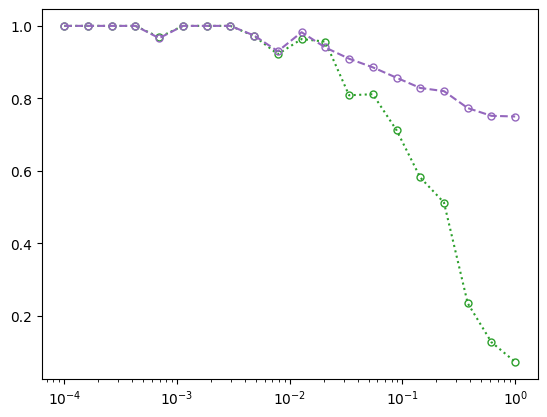

In [110]:
fig, ax = plt.subplots()

marker_style = dict(color='tab:green', linestyle=':', marker='o',
                    markersize=5)
ax.plot(ps, local_effs, fillstyle='none', **marker_style)

marker_style = dict(color='tab:purple', linestyle='--', marker='o',
                    markersize=5)
ax.plot(ps, global_effs, fillstyle='none', **marker_style)

ax.set_xscale('log')

#### using the efficiency

now that we know local and global efficiency are good replacements for average shortest path length and clustering coefficient. (again networkx just does it for undirected graph)
<br>


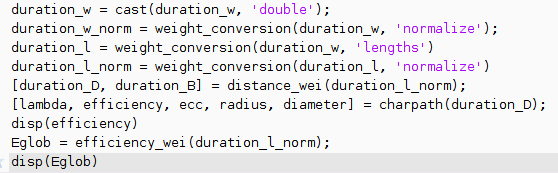<br>
this gives us the global efficiency. you should input the weights (similarities) and not distances. same goes for local.

```matlab
>> disp(mean(Eloc2))
    0.6879

>> disp(mean(Eloc1))
    0.8520

>> disp(Eglob)
    0.5236
```

matlab:<br>
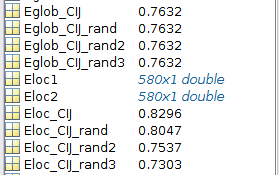<br>
this is for the lattice, p=0.1, 0.5 and 0.9 rewireing.</br>
problem is the global efficiency is not decreasing.

looks like I have a reading problem. the randomizer specifically says <b>randomizer_bin_und</b> meaning that it should work for only binary undirected networks and since I'm only trying to make the diagram, it is not necessary to have weights or directions.<br>
I decided to first make the lattice using <b>makelatticeCIJ.m</b>, then use a custom chat-GPT written <b>make_undirected.m</b> function to convert that to binary undirected.<br>
Finally, I can use the randomizer to make it more random and compute the efficiencies.

```matlab
latticized (ITER=5):
>> small_world
    0.5346

    0.8858

Randomized (ITER=5):
>> small_world
    0.5608

    0.6805

Duration Network:
>> small_world
    0.5236

    0.6879
```

With this observation, our network is slightly more locally efficient than a randomized network and even less globally efficient than a latticized network which is weird.

below numbers are produced only using a single randomized and a single latticized network so they're not reliable.

```matlab
>> small_world
    0.5236 (Eglob)

    0.6879 (Eloc)

    0.5605 (Eglob_rand)

    0.6746 (Eloc_rand)

    0.9526 (sigma)
```

and 

```matlab
>> small_world
    0.5236 (Eglob)

    0.6879 (Eloc)

    0.5607 (Eglob_rand)

    0.6756 (Eloc_rand)

    0.5348 (Eglob_latt)

    0.8858 (Eloc_latt)

    0.1573 (omega)
```

### rich clubs

all done by using brain connectivity toolbox.

# Explore

## import the network

In [4]:
import networkx as nx

# G = nx.read_edgelist('bst_full_norm.edgelist', create_using=nx.DiGraph)
# G = nx.read_gml('networks/Bike share ridership 2021-02.gml')
# G = nx.read_gml('networks/whole_network.gml')
G = nx.read_

In [5]:
G.number_of_nodes(), G.number_of_edges()

(605, 27798)

## Degree Distribution

In [97]:
import matplotlib.pyplot as plt
import numpy as np

bins = 9

# in_degrees = [deg for (id, deg) in G.in_degree(weight="tpd_weights") if deg > 0]
# out_degrees = [deg for (id, deg) in G.out_degree(weight="tpd_weights") if deg > 0]
# tot_degrees = [deg for (id, deg) in G.degree(weight="tpd_weights")]

in_degrees = [deg for (id, deg) in G.in_degree(weight="trip_count_weights") if deg > 0]
out_degrees = [deg for (id, deg) in G.out_degree(weight="trip_count_weights") if deg > 0]
tot_degrees = [deg for (id, deg) in G.degree(weight="trip_count_weights")]

# in_degrees = [deg for (id, deg) in G.in_degree(weight="duration_weights") if deg > 0]
# out_degrees = [deg for (id, deg) in G.out_degree(weight="duration_weights") if deg > 0]
# tot_degrees = [deg for (id, deg) in G.degree(weight="duration_weights")]

# in_degrees = [deg for (id, deg) in G.in_degree() if deg > 0]
# out_degrees = [deg for (id, deg) in G.out_degree() if deg > 0]
# tot_degrees = [deg for (id, deg) in G.degree()]

in_kmin = min(in_degrees)
in_kmax = max(in_degrees)
out_kmin = min(out_degrees)
out_kmax = max(out_degrees)
tot_kmin = min(tot_degrees)
tot_kmax = max(tot_degrees)

In [98]:
# Get 10 logarithmically spaced bins between kmin and kmax
in_bin_edges = np.logspace(np.log10(in_kmin), np.log10(in_kmax), num=bins + 1)

# histogram the data into these bins
in_density, _ = np.histogram(in_degrees, bins=in_bin_edges, density=True)

# Get 10 logarithmically spaced bins between kmin and kmax
out_bin_edges = np.logspace(np.log10(out_kmin), np.log10(out_kmax), num=bins + 1)

# histogram the data into these bins
out_density, _ = np.histogram(out_degrees, bins=out_bin_edges, density=True)

# Get 10 logarithmically spaced bins between kmin and kmax
tot_bin_edges = np.logspace(np.log10(tot_kmin), np.log10(tot_kmax), num=bins + 1)

# histogram the data into these bins
tot_density, _ = np.histogram(tot_degrees, bins=tot_bin_edges, density=True)

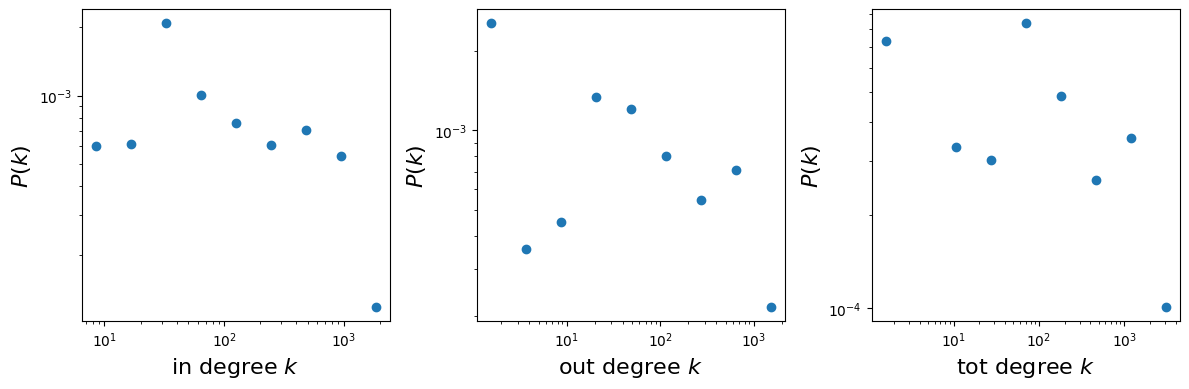

In [99]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))

# "x" should be midpoint (IN LOG SPACE) of each bin
in_log_be = np.log10(in_bin_edges)
in_x = 10**((in_log_be[1:] + in_log_be[:-1])/2)

out_log_be = np.log10(out_bin_edges)
out_x = 10**((out_log_be[1:] + out_log_be[:-1])/2)

tot_log_be = np.log10(tot_bin_edges)
tot_x = 10**((tot_log_be[1:] + tot_log_be[:-1])/2)

ax1.loglog(in_x, in_density, marker='o', linestyle='none')
ax1.set_xlabel(r"in degree $k$", fontsize=16)
ax1.set_ylabel(r"$P(k)$", fontsize=16)

ax2.loglog(out_x, out_density, marker='o', linestyle='none')
ax2.set_xlabel(r"out degree $k$", fontsize=16)
ax2.set_ylabel(r"$P(k)$", fontsize=16)

ax3.loglog(tot_x, tot_density, marker='o', linestyle='none')
ax3.set_xlabel(r"tot degree $k$", fontsize=16)
ax3.set_ylabel(r"$P(k)$", fontsize=16)

# Show the plot
fig.tight_layout()
plt.show()

In [100]:
# Get 20 logarithmically spaced bins between kmin and kmax
in_bin_edges = np.linspace(in_kmin, in_kmax, num=10)
out_bin_edges = np.linspace(out_kmin, out_kmax, num=10)
tot_bin_edges = np.linspace(tot_kmin, tot_kmax, num=10)

# histogram the data into these bins
in_density, _ = np.histogram(in_degrees, bins=in_bin_edges, density=True)
out_density, _ = np.histogram(out_degrees, bins=out_bin_edges, density=True)
tot_density, _ = np.histogram(tot_degrees, bins=tot_bin_edges, density=True)

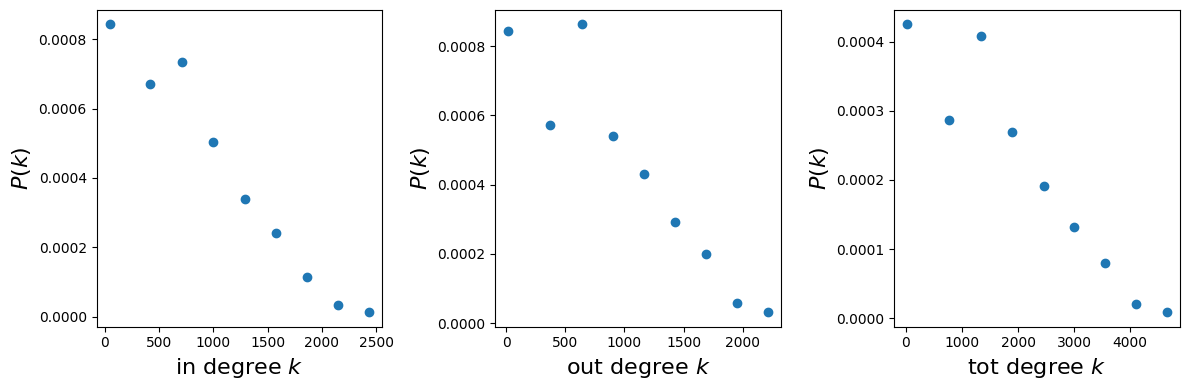

In [101]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))

# "x" should be midpoint (IN LOG SPACE) of each bin
in_log_be = np.log10(in_bin_edges)
in_x = 10**((in_log_be[1:] + in_log_be[:-1])/2)

out_log_be = np.log10(out_bin_edges)
out_x = 10**((out_log_be[1:] + out_log_be[:-1])/2)

tot_log_be = np.log10(tot_bin_edges)
tot_x = 10**((tot_log_be[1:] + tot_log_be[:-1])/2)

ax1.plot(in_x, in_density, marker='o', linestyle='none')
ax1.set_xlabel(r"in degree $k$", fontsize=16)
ax1.set_ylabel(r"$P(k)$", fontsize=16)

ax2.plot(out_x, out_density, marker='o', linestyle='none')
ax2.set_xlabel(r"out degree $k$", fontsize=16)
ax2.set_ylabel(r"$P(k)$", fontsize=16)

ax3.plot(tot_x, tot_density, marker='o', linestyle='none')
ax3.set_xlabel(r"tot degree $k$", fontsize=16)
ax3.set_ylabel(r"$P(k)$", fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

## partition into Biggest SCC and the rest

In [114]:
sccs = list(nx.strongly_connected_components(G))

In [115]:
scc_sizes = np.array([len(scc) for scc in sccs])
biggest_scc_size = max(scc_sizes)

In [116]:
is_bscc = (scc_sizes == biggest_scc_size)
bscc_index = np.argmax(scc_sizes)

In [117]:
G_bscc = G.subgraph(sccs[bscc_index])

## Average Shortest Path Length (for the biggest SCC) / Global Efficiency

In [119]:
## Distances are calculated as sums of weighted edges traversed. ?! (should inverse the weights to get distance)
def inverse_weight(attribute):

    def my_func(p1, p2, atts):
        if attribute in atts:
            return 1 / atts[attribute]
        else:
            return 1

    return my_func

# trip_count_weights as weight
avg_spl_trip_count = nx.average_shortest_path_length(G_bscc, weight=inverse_weight('trip_count_weights'))

# duration_weights as weight
avg_spl_duration = nx.average_shortest_path_length(G_bscc, weight=inverse_weight('duration_weights'))

# tpd_weights as weight
avg_spl_tpd = nx.average_shortest_path_length(G_bscc, weight=inverse_weight('tpd_weights'))

In [148]:
avg_spl_tpd

0.41962841878453994

## Average Clustering Coefficient (needs directions, either decide on a pattern or sum all of them) / Local Efficiency

## Centrality Measures (Degree / Eigenvector / PageRank), Betweenness (shortest path / random walk or current flow), Closeness or just global efficiency of a node)

### Eigenvector Centrality

In [121]:
# trip_count_weights as weight
eig_cent_trip_count = nx.eigenvector_centrality(G_bscc, weight='trip_count_weights')

# duration_weights as weight
eig_cent_duration = nx.eigenvector_centrality(G_bscc, weight='duration_weights')

# tpd_weights as weight
eig_cent_tpd = nx.eigenvector_centrality(G_bscc, weight='tpd_weights')

In [63]:
## the same as above? (it was in a short glance)

# trip_count_weights as weight
eig_cent_np_trip_count = nx.eigenvector_centrality_numpy(G_bscc, weight='trip_count_weights')

# duration_weights as weight
eig_cent_np_duration = nx.eigenvector_centrality_numpy(G_bscc, weight='duration_weights')

# tpd_weights as weight
eig_cent_np_tpd = nx.eigenvector_centrality_numpy(G_bscc, weight='tpd_weights')

### Shortest-Path Betweenness

In [122]:
## Weights are used to calculate weighted shortest paths, so they are interpreted as distances.
def inverse_weight(attribute):

    def my_func(p1, p2, atts):
        if attribute in atts:
            return 1 / atts[attribute]
        else:
            return 1

    return my_func
    
# trip_count_weights as weight
sp_bwns_cent_trip_count = nx.betweenness_centrality(G_bscc, weight=inverse_weight('trip_count_weights'))

# duration_weights as weight
sp_bwns_cent_duration = nx.betweenness_centrality(G_bscc, weight=inverse_weight('duration_weights'))

# tpd_weights as weight
sp_bwns_cent_tpd = nx.betweenness_centrality(G_bscc, weight=inverse_weight('tpd_weights'))

### Current Flow Betweenness

In [ ]:
## The weight reflects the capacity or the strength of the edge.

# trip_count_weights as weight
rw_bwns_cent_trip_count = nx.current_flow_betweenness_centrality(G_bscc, weight='trip_count_weights')

# duration_weights as weight
rw_bwns_cent_duration = nx.current_flow_betweenness_centrality(G_bscc, weight='duration_weights')

# tpd_weights as weight
rw_bwns_cent_tpd = nx.current_flow_betweenness_centrality(G_bscc, weight='tpd_weights')

## NetworkXNotImplemented: not implemented for directed type

### Closeness / Efficiency

In [123]:
## Weights are used to calculate weighted shortest paths, so they are interpreted as distances.
def inverse_weight(attribute):

    def my_func(p1, p2, atts):
        if attribute in atts:
            return 1 / atts[attribute]
        else:
            return 1

    return my_func
    
# trip_count_weights as weight
closeness_cent_trip_count = nx.closeness_centrality(G_bscc, distance=inverse_weight('trip_count_weights'))

# duration_weights as weight
closeness_cent_duration = nx.closeness_centrality(G_bscc, distance=inverse_weight('duration_weights'))

# tpd_weights as weight
closeness_cent_tpd = nx.closeness_centrality(G_bscc, distance=inverse_weight('tpd_weights'))

In [124]:
non_bscc_ids = set(G.nodes()) - set(G_bscc.nodes())

In [129]:
def add_default_value(attribute, keys):

    min_value = min(attribute.values())
    
    for key in keys:
        attribute[key] = min_value


In [134]:
add_default_value(closeness_cent_trip_count, non_bscc_ids)
add_default_value(closeness_cent_duration, non_bscc_ids)
add_default_value(closeness_cent_tpd, non_bscc_ids)

add_default_value(eig_cent_trip_count, non_bscc_ids)
add_default_value(eig_cent_duration, non_bscc_ids)
add_default_value(eig_cent_tpd, non_bscc_ids)

add_default_value(sp_bwns_cent_duration, non_bscc_ids)
add_default_value(sp_bwns_cent_trip_count, non_bscc_ids)
add_default_value(sp_bwns_cent_tpd, non_bscc_ids)

In [136]:
nx.set_node_attributes(G, closeness_cent_trip_count, name='closeness_cent_trip_count')
nx.set_node_attributes(G, closeness_cent_duration, name='closeness_cent_duration')
nx.set_node_attributes(G, closeness_cent_tpd, name='closeness_cent_tpd')

nx.set_node_attributes(G, eig_cent_trip_count, name='eig_cent_trip_count')
nx.set_node_attributes(G, eig_cent_duration, name='eig_cent_duration')
nx.set_node_attributes(G, eig_cent_tpd, name='eig_cent_tpd')

nx.set_node_attributes(G, sp_bwns_cent_duration, name='sp_bwns_cent_duration')
nx.set_node_attributes(G, sp_bwns_cent_trip_count, name='sp_bwns_cent_trip_count')
nx.set_node_attributes(G, sp_bwns_cent_tpd, name='sp_bwns_cent_tpd')


In [143]:
show_feature = {k: (1 if k in sccs[bscc_index] else 0) for k in G.nodes()}
nx.set_node_attributes(G, show_feature, name='on_bscc')


In [144]:
nx.write_gml(G, "networks/Bike share ridership 2021-02 (processed).gml")

## Motifs Analysis

## Rich Clubs

## Small-Worlds

## Community Detection Algorithm

In [18]:
communities = nx.community.louvain_communities(G, weight='duration_weights', resolution=1)

In [19]:
[len(c) for c in communities]

[86, 88, 104, 95, 97, 88, 41, 2, 4]

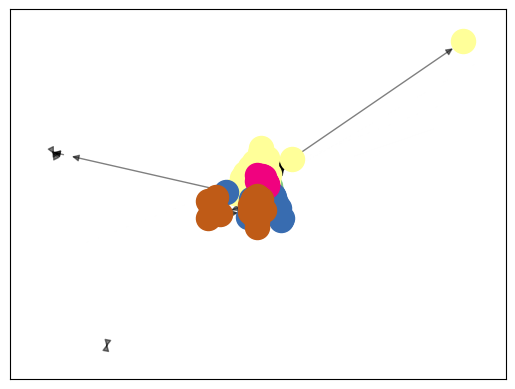

In [37]:
import networkx as nx
import matplotlib.pyplot as plt

pos = nx.spring_layout(G, weight='duration_weights')
# nx.draw(G, pos=pos)
colors = ['#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0', '#f0027f', '#bf5b17']
communities = communities[:7]

for i, community in enumerate(communities):
    
    nx.draw_networkx_nodes(G, pos, nodelist=community, node_color=colors[i])

nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

plt.show()